**<span style="color: orange;">NOTE: This code is still work in progress.</span>**


## Import necessary libraries for data manipulation, visualization, and machine learning

In [1]:
import pickle  #For saving/loading models - Recently added (8/14/2024)
import sys

import pandas as pd  # Data manipulation library
import numpy as np  # Numerical operations library
import matplotlib.pyplot as plt  # Plotting library
import os  # Operating system interface
import glob  # File path expansion
from datetime import date, timedelta  # Date and time handling
from dateutil import parser  # Date parsing utility
from netCDF4 import Dataset  # NetCDF file handling
import cartopy.crs as ccrs  # Cartographic projections
import cartopy.feature as cfeature  # Cartographic features
import scipy.io  # Input and output with MATLAB files
from scipy import interpolate  # Interpolation methods
from scipy.stats import linregress  # Linear regression
from pylab import rcParams  # Customizing Matplotlib parameters
import seaborn as sb  # Statistical data visualization
from collections import Counter  # Container data type with counting abilities
import warnings  # Warning control

from sklearn import preprocessing  # Data preprocessing
from sklearn import metrics  # Evaluation metrics for machine learning
from sklearn.preprocessing import StandardScaler  # Standardization of features
from sklearn.preprocessing import scale  # Standardization of features
from sklearn.model_selection import train_test_split  # Data splitting for training and testing
from sklearn.model_selection import cross_val_predict  # Cross-validated predictions
from sklearn.model_selection import cross_val_score  # Cross-validated scores
from sklearn.metrics import classification_report  # Classification performance report
from sklearn.metrics import confusion_matrix  # Confusion matrix
from sklearn.decomposition import PCA  # Principal component analysis

# Import machine learning models from scikit-learn
from sklearn.linear_model import (
    LogisticRegression,
    Ridge,
    Lasso,
    LinearRegression,
    SGDRegressor,
    ElasticNet,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    AdaBoostRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    VotingRegressor,
    StackingRegressor,
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

# Import Matplotlib utilities for plotting
from matplotlib.patches import RegularPolygon, Ellipse, Patch
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
import matplotlib.colors as colors

# Import additional Matplotlib utilities
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mc
import shap  # SHAP (SHapley Additive exPlanations) values for interpretability
import matplotlib  # Base plotting library

# For training - extra libraries
from IPython.display import display, Markdown
import time
import progressbar

# Import PyTorch libraries
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network module
import torch.optim as optim  # Optimization algorithms
import torch.utils.data as data  # Data handling utilities
from torch.utils.data import DataLoader, TensorDataset

#Clearing output
from IPython.display import clear_output
def clear_cell_output():
    clear_output(wait=True)

## Data Preparation

**Input variables:**

- Vapor pressure deficit (VPD)
- Temperature (max)
- Precipitation
- Potential evapotranspiration (PET)
- Evapotranspiration (ET)
- Palmer Drought Severity Index (PDSI)
- Evaporative Demand Drought Index (EDDI)
- Soil moisture
- Water equivalent drought index (SWEI)

**Outcome or target variable:**

- PM2.5

In [2]:
# Parameters related to the directory where data is stored
directory = '../../../farnazhp/Fire/'

# Parameters related to date and time
fm_yr_start = 1996  # Start year
fm_yr_end   = 2020  # End year
YEARS  = np.arange(fm_yr_start, fm_yr_end+1)  # Array of years

MONTHS = np.arange(7, 10)  # Array of months (July to September)
DAYS1  = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Days in each month for non-leap years
DAYS2  = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Days in each month for leap years

# Coordinates of the target region (US west)
lat1 = 28.  # Minimum latitude
lat2 = 52.  # Maximum latitude
lon1 = -127.  # Minimum longitude
lon2 = -100.  # Maximum longitude

### Read emission data (from 1996 to 2020) (outcome)

In [3]:
# Specify the filename for the PM2.5 data
npz_fname = 'PM2p5_JAS_1996_2020_24km_west.npz'

# Load the data from the specified file, allowing pickling of objects
data = np.load(directory + npz_fname, allow_pickle=True)

# Extract the PM2.5 data from the loaded file
pm2p5 = data['PM2p5_seas_24km']

# Close the loaded file
data.close()

### Read input variables

In [4]:
# Load various climate data from saved numpy files

# Load VPD (Vapor Pressure Deficit) data - For humidity
npz_fname = 'vpd_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
lat = data['lat_vpd_24']
lon = data['lon_vpd_24']
dates = data['dates_vpd_seas_yr']
vpd = data['vpd_seas_yr_24km_west']
data.close()

# Load maximum temperature data
npz_fname = 'tmmx_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
tmmx = data['tmmx_seas_yr_24km_west']
data.close()

npz_fname = 'wsmx_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
wsmx = data['wsmx_seas_yr_24km_west']
data.close()

npz_fname = 'elev_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
elev = data['elev_seas_yr_24km_west']
data.close()
############ Moisture in environment ############
# Load ETR (Reference Evapotranspiration) data
npz_fname = 'etr_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
etr = data['etr_seas_yr_24km_west']
data.close()

# Load PET (Potential Evapotranspiration) data
npz_fname = 'pet_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
pet = data['pet_seas_yr_24km_west']
data.close()
#################################################
# Load precipitation data
npz_fname = 'pr_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
pr = data['pr_seas_yr_24km_west']
data.close()

# Load NDVI (Normalized Difference Vegetation Index) data
npz_fname = 'ndvi_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
ndvi = data['ndvi_seas_yr_24km_west']
data.close()

# Load SWE (Snow Water Equivalent) data
npz_fname = 'swe_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
swe = data['swe_seas_yr_24km_west']
data.close()

# Load soil moisture data
npz_fname = 'sm_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
sm = data['sm_seas_yr_24km_west']
data.close()

# Load PDSI (Palmer Drought Severity Index) data
npz_fname = 'pdsi_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
pdsi = data['pdsi_seas_yr_24km_west']
data.close()

# Load EDDI (Standardized Evapotranspiration Deficit Index) data
npz_fname = 'eddi_JAS_1996_2020_24km_west.npz'
data = np.load(directory + npz_fname, allow_pickle=True)
eddi = data['eddi_seas_yr_24km_west']
data.close()

In [5]:
# Display the shapes of the loaded PM2.5, tmmx, lat, lon, and dates arrays
pm2p5.shape, tmmx.shape, lat.shape, lon.shape, dates.shape

((2300, 86, 100), (2300, 86, 100), (86,), (100,), (2300,))

## Map Preparation

In [6]:
# Ignore RuntimeWarnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Calculate time mean (average) of variables:
vpd_mean = np.nanmean(vpd, 0)
tmmx_mean = np.nanmean(tmmx, 0)
wsmx_mean = np.nanmean(wsmx, 0)
elev_mean = np.nanmean(elev, 0)
etr_mean = np.nanmean(etr, 0)
pet_mean = np.nanmean(pet, 0)
pr_mean = np.nanmean(pr, 0)
swe_mean = np.nanmean(swe, 0)
sm_mean = np.nanmean(sm, 0)
pdsi_mean = np.nanmean(pdsi, 0)
eddi_mean = np.nanmean(eddi, 0)
ndvi_mean = np.nanmean(ndvi, 0)
pm2p5_mean = np.nanmean(pm2p5, 0)
pm2p5_mean = np.nanmean(pm2p5, 0)

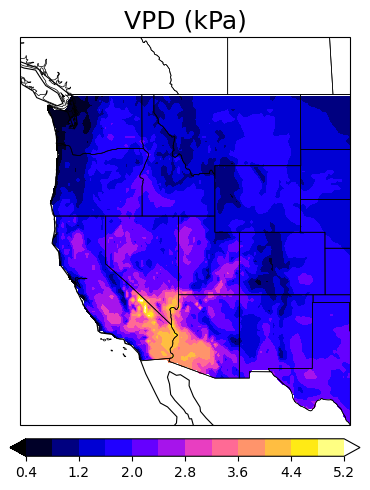

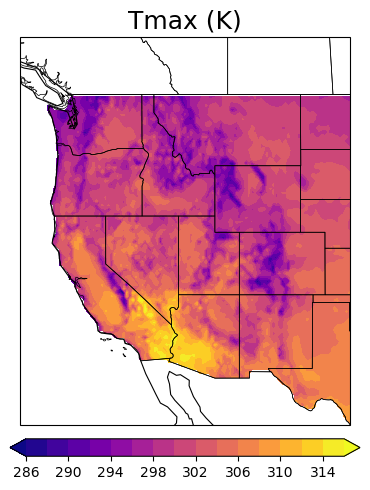

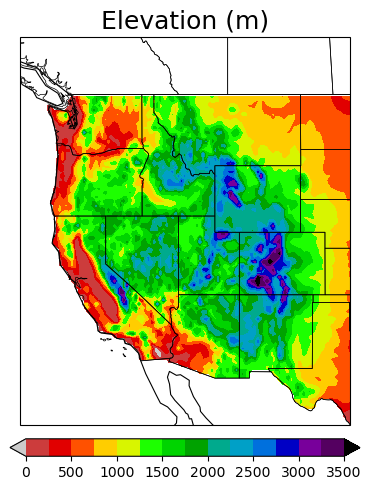

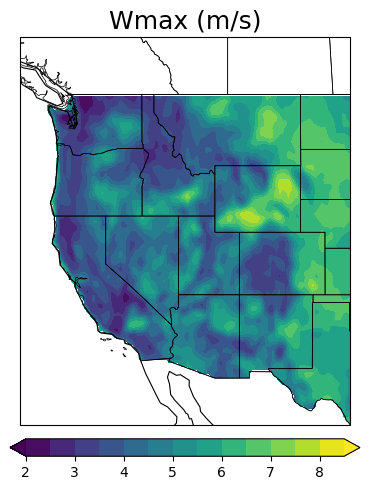

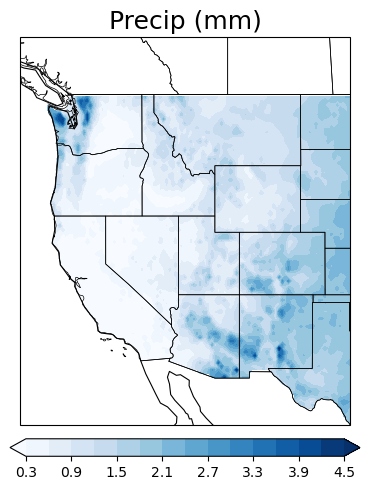

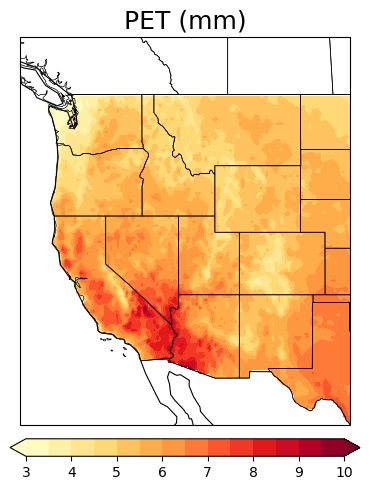

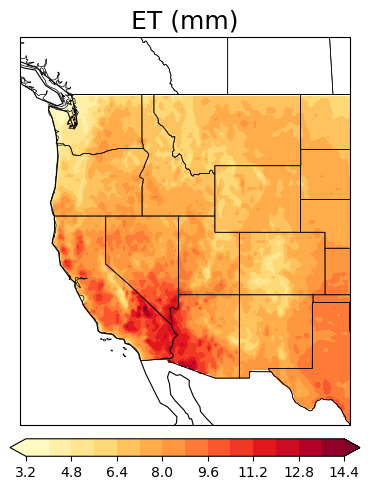

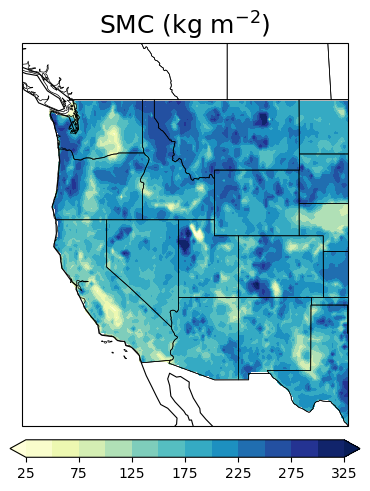

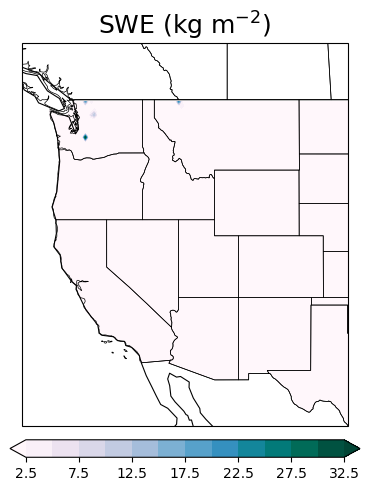

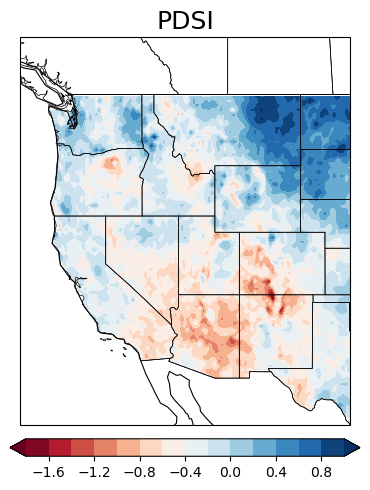

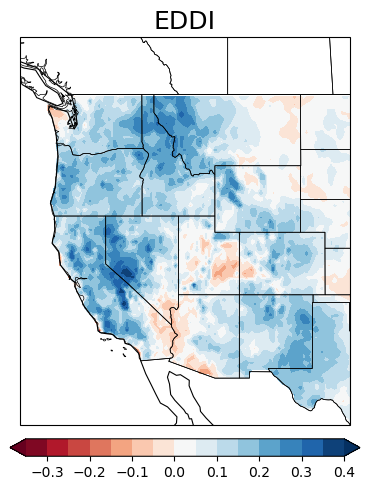

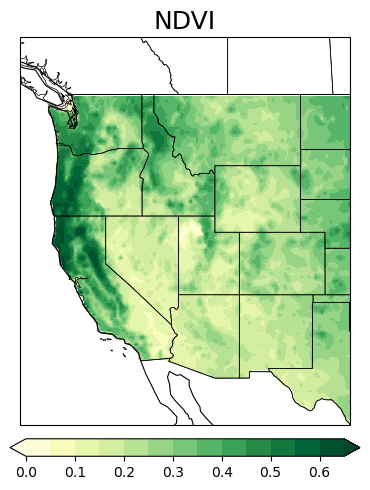

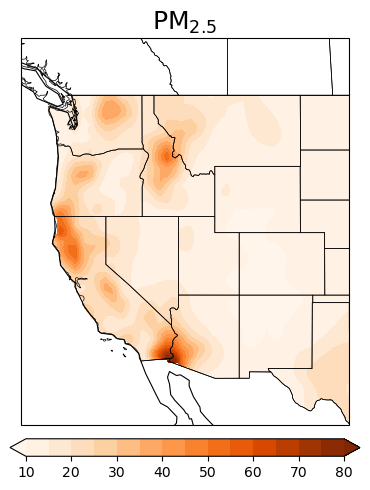

In [7]:
# Simplified plotting into a function
def plot_map(data, title, cmap, lon, lat, clevs, lon1, lon2, lat1, lat2, colorbar_ticks=None):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection=ccrs.Mercator())
    
    csf = ax.contourf(lon, lat, data, clevs, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.8)
    ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    plt.title(title, fontsize=18)
    cb = plt.colorbar(csf, shrink=0.7, pad=0.03, orientation='horizontal')
    if colorbar_ticks:
        cb.set_ticks(colorbar_ticks)
    
    plt.tight_layout(pad=0)
    plt.show()

# Init common variables
lat2_alt = 50
clevs = 15

# Plot VPD
plot_map(vpd_mean, 'VPD (kPa)', 'gnuplot2', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot Tmax
plot_map(tmmx_mean, 'Tmax (K)', 'plasma', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot elevation
plot_map(elev_mean, 'Elevation (m)', 'nipy_spectral_r', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot Wmax
plot_map(wsmx_mean, 'Wmax (m/s)', 'viridis', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot precip
plot_map(pr_mean, 'Precip (mm)', 'Blues', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot potential evapotranspiration
plot_map(pet_mean, 'PET (mm)', 'YlOrRd', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot Evapotranspiration
plot_map(etr_mean, 'ET (mm)', 'YlOrRd', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot Soil moisture
plot_map(sm_mean, 'SMC (kg m$^{-2}$)', 'YlGnBu', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot Snow Water Equivalent
plot_map(swe_mean, 'SWE (kg m$^{-2}$)', 'PuBuGn', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot PDSI
plot_map(pdsi_mean, 'PDSI', 'RdBu', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot EDDI
plot_map(eddi_mean, 'EDDI', 'RdBu', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot NDVI
plot_map(ndvi_mean, 'NDVI', 'YlGn', lon, lat, clevs, lon1, lon2, lat1, lat2)
# Plot PM2.5
plot_map(pm2p5_mean, 'PM$_{2.5}$', 'Oranges', lon, lat, clevs, lon1, lon2, lat1, lat2)

## Initializing MLAs for PM2.5 prediction

In [8]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# Dictionary of regression models
all_MLAs = {
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'LSTM': 'lstm'  # Placeholder for LSTM
}


"""
    'Gradient Boost': GradientBoostingRegressor(random_state=0, verbose=1),
    'Ada Boost': AdaBoostRegressor(random_state=0, verbose=1),
    'Random Forest': RandomForestRegressor(random_state=0, verbose=1),
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'LSTM': 'lstm'  # Placeholder for LSTM
    -----
    'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Ada Boost': AdaBoostRegressor(random_state=0),
    'Random Forest': RandomForestRegressor(random_state=0),
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(random_state=0),
    'SVR': SVR(),
    'LSTM': 'lstm'  # Placeholder for LSTM
    -----
    'Gradient Boost': GradientBoostingRegressor(random_state=0, verbose=1),
    'Ada Boost': AdaBoostRegressor(random_state=0, verbose=1),
    'Random Forest': RandomForestRegressor(random_state=0, verbose=1),
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(random_state=0),
    'SVR': SVR(),
"""

# Lists to store regression results
ML_name      = []
ML_slope     = []
ML_intercept = []
ML_r_value   = []
ML_p_value   = []
ML_std_err   = []

## Prepare the big data for training and testing

In [9]:
#Converting to weekly and 48 km, cause daily cannot be done due to memory issues
def calc_wk_mn(var2):
    var = var2[:,::2,::2].copy()
    var_week = np.zeros((len(np.arange(0,var.shape[0],7)), var.shape[1],var.shape[2])) 
    var_week[:] = np.nan
    nn = 0
    for i in range(0,len(var),7):
        var_week[nn,:,:] = np.nanmean(var[i:i+7,:,:],0)
        nn += 1
    return var_week

vpd_wk = calc_wk_mn(vpd)
tmmx_wk = calc_wk_mn(tmmx)
wsmx_wk = calc_wk_mn(wsmx)
elev_wk = calc_wk_mn(elev)
etr_wk = calc_wk_mn(etr)
pet_wk = calc_wk_mn(pet)
pr_wk = calc_wk_mn(pr)
swe_wk = calc_wk_mn(swe)
sm_wk = calc_wk_mn(sm)
pdsi_wk = calc_wk_mn(pdsi)
eddi_wk = calc_wk_mn(eddi)
ndvi_wk = calc_wk_mn(ndvi)
pm2p5_wk = calc_wk_mn(pm2p5)

In [10]:
# Reshape 2D arrays to 1D arrays and remove values where NDVI is NaN
vpd_new = vpd_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
tmmx_new = tmmx_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
wsmx_new = wsmx_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
elev_new = elev_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
etr_new = etr_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
pet_new = pet_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
pr_new = pr_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
swe_new = swe_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
sm_new = sm_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
pdsi_new = pdsi_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
eddi_new = eddi_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
ndvi_new = ndvi_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]
pm2p5_new = pm2p5_wk.reshape(-1)[np.isnan(ndvi_wk.reshape(-1)) == 0]

# Remove additional values where PDSI is NaN
vpd_new = vpd_new[np.isnan(pdsi_new) == 0]
tmmx_new = tmmx_new[np.isnan(pdsi_new) == 0]
wsmx_new = wsmx_new[np.isnan(pdsi_new) == 0]
elev_new = elev_new[np.isnan(pdsi_new) == 0]
etr_new = etr_new[np.isnan(pdsi_new) == 0]
pet_new = pet_new[np.isnan(pdsi_new) == 0]
pr_new = pr_new[np.isnan(pdsi_new) == 0]
swe_new = swe_new[np.isnan(pdsi_new) == 0]
sm_new = sm_new[np.isnan(pdsi_new) == 0]
eddi_new = eddi_new[np.isnan(pdsi_new) == 0]
ndvi_new = ndvi_new[np.isnan(pdsi_new) == 0]
pm2p5_new = pm2p5_new[np.isnan(pdsi_new) == 0]
pdsi_new = pdsi_new[np.isnan(pdsi_new) == 0]

# Replace zero values in SWE and Precip with small values to avoid issues in further analysis
swe_new[swe_new == 0] = 1e-24
pr_new[pr_new == 0] = 1e-24

# Create dataframes for each variable
vpd_new_df = pd.DataFrame(vpd_new, columns=['VPD'])
tmmx_new_df = pd.DataFrame(tmmx_new, columns=['Tmax'])
wsmx_new_df = pd.DataFrame(wsmx_new, columns=['Wmax'])
elev_new_df = pd.DataFrame(elev_new, columns=['Elev'])
etr_new_df = pd.DataFrame(etr_new, columns=['ET'])
pet_new_df = pd.DataFrame(pet_new, columns=['PET'])
pr_new_df = pd.DataFrame(pr_new, columns=['Prec'])
swe_new_df = pd.DataFrame(swe_new, columns=['SWE'])
sm_new_df = pd.DataFrame(sm_new, columns=['SM'])
eddi_new_df = pd.DataFrame(eddi_new, columns=['EDDI'])
pdsi_new_df = pd.DataFrame(pdsi_new, columns=['PDSI'])
ndvi_new_df = pd.DataFrame(ndvi_new, columns=['NDVI'])
pm2p5_new_df = pd.DataFrame(pm2p5_new, columns=['PM2.5'])

# Concatenate all dataframes into one
df = pd.concat([vpd_new_df, tmmx_new_df, wsmx_new_df, elev_new_df, etr_new_df, pet_new_df,
                pr_new_df, swe_new_df, sm_new_df,
                eddi_new_df, pdsi_new_df, ndvi_new_df, pm2p5_new_df], axis=1)

# Check for NaNs and display statistical summary
print(df.isna().sum())
df.describe(include='all')

VPD      0
Tmax     0
Wmax     0
Elev     0
ET       0
PET      0
Prec     0
SWE      0
SM       0
EDDI     0
PDSI     0
NDVI     0
PM2.5    0
dtype: int64


,VPD,Tmax,Wmax,Elev,ET,PET,Prec,SWE,SM,EDDI,PDSI,NDVI,PM2.5
count,531335.000000,531335.000000,531335.000000,531335.000000,531335.000000,531335.000000,5.313350e+05,5.313350e+05,531335.000000,531335.000000,531335.000000,531335.000000,531335.000000
mean,1.751279,301.570280,4.802376,1340.844491,7.634071,5.630765,1.110416e+00,4.377909e-02,187.364318,0.104918,-0.250722,0.263988,16.747813
std,0.799662,5.830000,1.412317,662.345811,2.086215,1.451518,1.825849e+00,2.815659e+00,49.229333,0.883267,2.434548,0.141105,38.644938
min,0.007143,274.271429,1.134726,-60.040186,0.971429,0.957143,1.000000e-24,1.000000e-24,0.000000,-2.090000,-7.265143,-0.017002,2.562937
25%,1.190000,297.885714,3.685391,844.320115,6.228571,4.657143,1.000000e-24,1.000000e-24,158.180639,-0.508571,-2.146571,0.159216,8.037450
50%,1.641429,302.000000,4.649645,1318.839242,7.557143,5.642857,3.714286e-01,1.000000e-24,188.353712,0.113143,-0.903143,0.231406,10.907670
75%,2.170000,305.571429,5.783654,1778.360860,8.914286,6.571429,1.471429e+00,1.000000e-24,219.692285,0.722571,1.586571,0.337607,15.823456
max,7.505714,322.200000,11.376378,3478.518697,19.657143,12.928571,5.988571e+01,5.076172e+02,414.986691,2.090000,13.805714,0.906659,3234.309335


In [11]:
# show content of dataframe
df

,VPD,Tmax,Wmax,Elev,ET,PET,Prec,SWE,SM,EDDI,PDSI,NDVI,PM2.5
0,0.547143,293.657143,3.581441,37.159287,3.957143,3.571429,1.042857e+00,1.000000e-24,97.624525,-0.437714,2.240571,0.170970,10.213194
1,0.872857,295.814286,2.646776,415.715236,4.471429,3.885714,2.357143e+00,1.000000e-24,262.289358,-0.138000,2.506571,0.433825,9.228708
2,1.030000,294.314286,2.514253,1178.041672,5.828571,4.600000,1.642857e+00,1.714648e+02,241.221952,0.070000,2.234571,0.212995,7.369665
3,0.934286,293.814286,2.590062,1342.041263,5.900000,4.642857,9.857143e-01,8.320455e+01,300.538243,0.151714,1.765714,0.179777,5.982828
4,0.607143,290.042857,3.417526,1738.919503,5.042857,4.114286,8.571429e-02,1.000000e-24,351.903589,0.109714,1.756571,0.204908,5.274608
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531330,2.040000,302.375000,5.230435,1088.795210,8.875000,6.075000,1.000000e-24,1.000000e-24,187.895177,0.210000,-2.235000,0.196418,19.172706
531331,1.867500,303.800000,6.326072,318.800051,7.875000,5.500000,1.000000e-24,1.000000e-24,164.581312,-0.520000,-1.780000,0.390140,18.684257
531332,1.730000,303.125000,5.406497,401.880459,7.675000,5.425000,1.000000e-24,1.000000e-24,200.630849,-0.325000,-2.350000,0.469633,16.810871
531333,1.905000,304.550000,5.317310,224.959623,7.550000,5.425000,1.000000e-24,1.000000e-24,191.375537,-0.610000,-1.180000,0.442173,16.561379


## Model Performance Evaluation

In [12]:
# Drop specified columns from the DataFrame
df_new = df.drop(['PET', 'SWE'], axis=1)

# Standardize the inputs using StandardScaler
sc = StandardScaler()
df_scaled = sc.fit_transform(df_new.values)
df_scaled = pd.DataFrame(df_scaled, columns=df_new.columns)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled.drop(['PM2.5'], axis=1).values, df_scaled['PM2.5'].values, test_size=0.2, random_state=10)
X_train_df = pd.DataFrame(data=X_train, columns=df_scaled.drop(['PM2.5'], axis=1).columns)
X_test_df  = pd.DataFrame(data=X_test , columns=df_scaled.drop(['PM2.5'], axis=1).columns)

In [13]:
# Convert seconds into a string formatted as hours, minutes, and seconds
def format_duration(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60  # Keeping seconds as a float for decimals
    
    # Format seconds to 2 decimal places
    formatted_seconds = f"{seconds:.2f}"
    # Remove trailing .00 if the seconds value is an integer
    if formatted_seconds.endswith('.00'):
        formatted_seconds = formatted_seconds[:-3]  # Remove the '.00'
    
    if hours > 0:
        return f"{hours}h {minutes}m {formatted_seconds}s"
    elif minutes > 0:
        return f"{minutes}m {formatted_seconds}s"
    else:
        return f"{formatted_seconds}s"

Sampled Scaled Features for Row 0:
[-0.08735012 -0.04881067 -0.0800411   0.70343391 -0.08480817 -0.49080224
  0.18108577  1.02178783  0.71911663 -0.50654952] 

Sampled Target Value for Row 0:
-0.11667597397262484 



```Training will begin shortly...```

  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


Training model: Decision Tree
Saved Decision Tree model to saved_algorithms/Decision Tree_model.pkl
Decision Tree took 11.29 seconds to train.


 50% (1 of 2) |#############             | Elapsed Time: 0:00:12 ETA:   0:00:12


Training model: LSTM
Epoch 20 / 20  
LSTM Training loop complete.


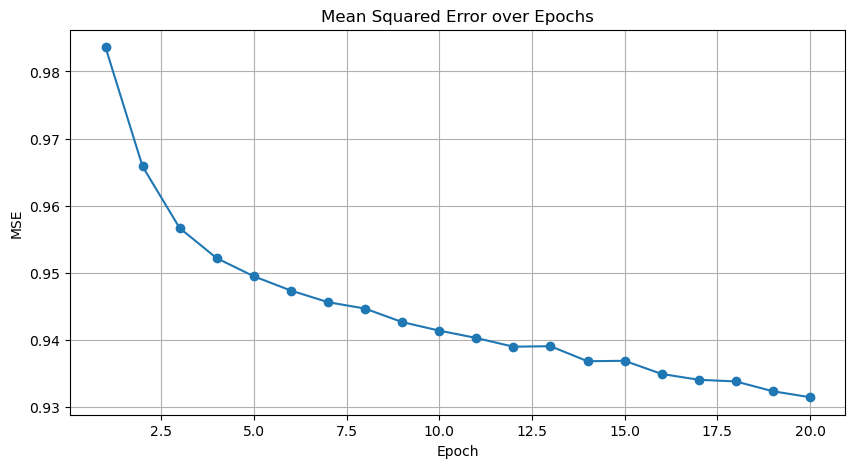

Saved LSTM model to saved_algorithms/LSTM_model.pth
LSTM took 127.67 seconds to train.


100% (2 of 2) |##########################| Elapsed Time: 0:02:20 Time:  0:02:20


**Training times for all models:**

``Decision Tree: 11.29s``

``LSTM: 2m 7.67s``

In [14]:
# Define fraction of data to use for training
Training_Fraction = 1  # Example: 10%
save_models_toggle = True

# Create directory for saving models
save_dir = 'saved_algorithms'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Sample a fraction of the data
if Training_Fraction == 1:
    X_train_sample = X_train
    Y_train_sample = Y_train
else:
    X_train_sample, _, Y_train_sample, _ = train_test_split(X_train, Y_train, train_size=Training_Fraction, random_state=0)

# Set up progress bar
bar = progressbar.ProgressBar(max_value=len(all_MLAs))

# Check row 0
print("Sampled Scaled Features for Row 0:")
print(X_train_sample[0], "\n")

print("Sampled Target Value for Row 0:")
print(Y_train_sample[0], "\n")

# Initialize lists to store training times
training_times = []

display(Markdown("```Training will begin shortly...```"))
time.sleep(2)

#This will be used for SHAP values later for LSTM
lstm_trained_model = None
#This will be replaced with the model

# Loop through each model in the dictionary
for i, (Name, ML) in enumerate(all_MLAs.items()):
    #clear_cell_output()
    start_time = time.time()  # Start timing
    bar.update(i)

    print(f"\nTraining model: {Name}")
    
    if Name == 'LSTM':
        # Prepare data for LSTM
        
        X_train_tensor = torch.tensor(X_train_sample, dtype=torch.float32).unsqueeze(1)  # Add time dimension
        Y_train_tensor = torch.tensor(Y_train_sample, dtype=torch.float32)
        dataset = TensorDataset(X_train_tensor, Y_train_tensor)
        #Tested with batch_Size 64
        #Testing with 10 - took too long...
        #Testing with 400
        
        dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

        # Define model, loss function, and optimizer
        model = LSTMModel(input_dim=X_train_tensor.shape[2], hidden_dim=50, output_dim=1)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        #Test learning rate 0.0001(?)

        # Training loop
        #epochs = 10
        epochs = 20
        #Test 120
        ## Keep track of MSE
        mse_list = []  # List to store MSE for each epoch
        
        
        for epoch in range(epochs):  # Number of epochs
            epoch_losses = []
            
            # Print the epoch information with a carriage return
            sys.stdout.write(f"\rEpoch {epoch+1} / {epochs}  ")
            sys.stdout.flush()  # Ensure the output is immediately flushed to the terminal

            for inputs, targets in dataloader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Inside the training loop after `optimizer.step()`:
                epoch_losses.append(loss.item())

            # Calculate average MSE for this epoch
            average_mse = sum(epoch_losses) / len(epoch_losses)
            mse_list.append(average_mse)
        
        #Added plotting for LSTM
       
        
        print("\nLSTM Training loop complete.")

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), mse_list, marker='o')
        plt.title('Mean Squared Error over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

        
        # Predict on the test data
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
        with torch.no_grad():
            Y_pred_tensor = model(X_test_tensor)
        Y_pred = Y_pred_tensor.squeeze().numpy()

        # Calculate linear regression statistics
        slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)
        
        # Append results to respective lists
        ML_slope.append(slope) 
        ML_intercept.append(intercept) 
        ML_r_value.append(r_value) 
        ML_p_value.append(p_value) 
        ML_std_err.append(std_err) 
        ML_name.append(Name)
    
        lstm_trained_model = model
        # Save the LSTM model if toggled
        if save_models_toggle:
            model_save_path = os.path.join(save_dir, f"{Name}_model.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved LSTM model to {model_save_path}")
    else:
        try:
            # Fit the model on the sampled training data
            ML.fit(X_train_sample, Y_train_sample)
            #ML.fit(X_train, Y_train)
            
            # Predict on the test data
            Y_pred = ML.predict(X_test)
            
            # Calculate linear regression statistics
            slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)
            
            # Append results to respective lists
            ML_slope.append(slope) 
            ML_intercept.append(intercept) 
            ML_r_value.append(r_value) 
            ML_p_value.append(p_value) 
            ML_std_err.append(std_err) 
            ML_name.append(Name)
        
            # Save the Scikit-learn model if toggled
            if save_models_toggle:
                model_save_path = os.path.join(save_dir, f"{Name}_model.pkl")
                with open(model_save_path, 'wb') as file:
                    pickle.dump(ML, file)
                print(f"Saved {Name} model to {model_save_path}")
        
        except Exception as e:
            print(f"{Name} failed to train: {e}")
    
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    training_times.append((Name, elapsed_time))  # Store the training time
    print(f"{Name} took {elapsed_time:.2f} seconds to train.")
    time.sleep(1)

#Finish
#clear_cell_output()
bar.finish()

# Print summary of training times
display(Markdown("**Training times for all models:**"))
for model_name, duration in training_times:
    formatted_duration = format_duration(duration)
    markdown_str = f"``{model_name}: {formatted_duration}``"
    display(Markdown(markdown_str))

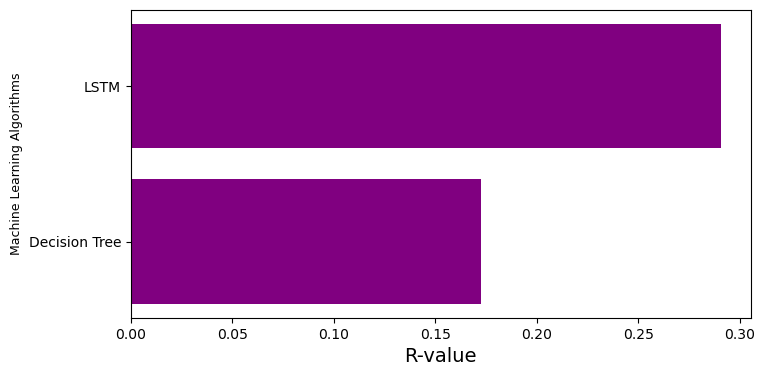

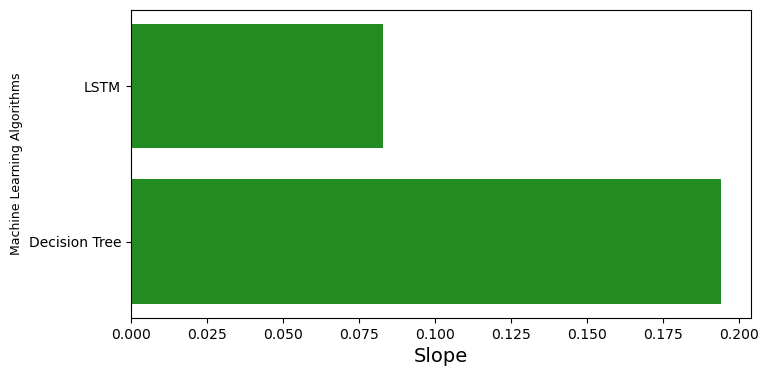

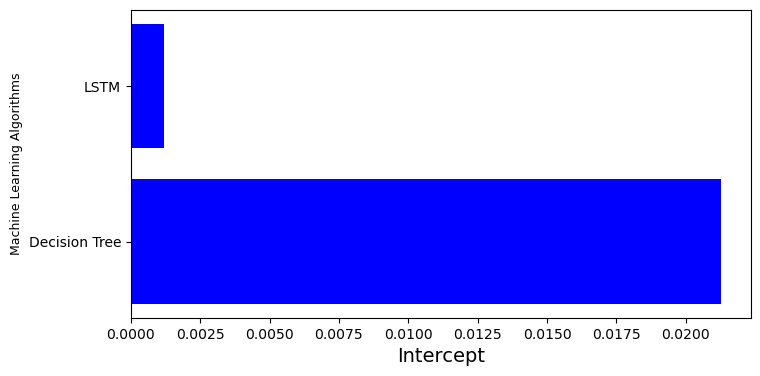

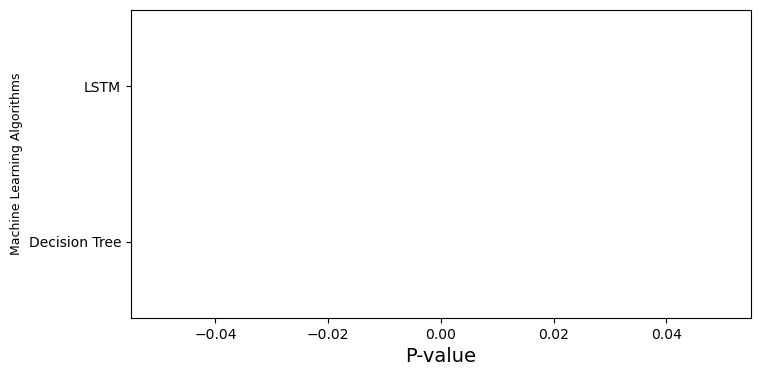

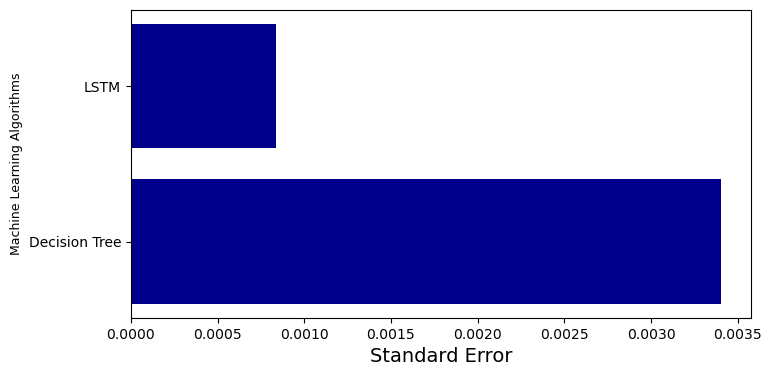

In [15]:
def plot_horizontal_bar(ML_name, ML_values, color, label, data_fraction, ylim=None):
    plt.figure(figsize=(8, 4))
    plt.barh(ML_name, ML_values, color=color)
    plt.xlabel(label, fontsize='14')
    plt.ylabel(set_ylabel(data_fraction), fontsize='9')
    if ylim:
        plt.xlim(ylim)
    plt.show()

def set_ylabel(data_fraction):
    return (
        'Machine Learning Algorithms' if data_fraction == 1.0
        else f'Machine Learning Algorithms ({data_fraction * 100:.0f}% Data)'
    )

# Plot R-values
plot_horizontal_bar(ML_name, ML_r_value, 'purple', 'R-value', Training_Fraction)
# Plot Slope
plot_horizontal_bar(ML_name, ML_slope, 'forestgreen', 'Slope', Training_Fraction)
# Plot Intercept
plot_horizontal_bar(ML_name, ML_intercept, 'blue', 'Intercept', Training_Fraction)
# Plot P-value
plot_horizontal_bar(ML_name, ML_p_value, 'red', 'P-value', Training_Fraction)
# Plot Standard Error
plot_horizontal_bar(ML_name, ML_std_err, 'darkblue', 'Standard Error', Training_Fraction)

## SHAP Investigation - Feature Importance

**<span style="color: red;">NOTE: This code is still work in progress and may be unstable as of this build (8/23/2024)</span>**


In [16]:
# Function to compute and plot SHAP values for a given model
def compute_and_plot_shap(model, X_train, X_test, feature_names, model_name, subset_fraction=0.1):
    # Compute subset of the data
    subset_size_train = int(len(X_train) * subset_fraction)
    subset_size_test = int(len(X_test) * subset_fraction)
    
    X_train_subset = X_train[:subset_size_train]
    X_test_subset = X_test[:subset_size_test]
    
    # Sample background data to reduce size (use fraction of data here)
    background_data = shap.sample(X_train_subset, nsamples=100)  # Adjust nsamples
    # background_data = shap.sample(X_train, nsamples=100)  # Old line: using full X_train
    # Alternatively, use k-means clustering:
    # background_data = shap.kmeans(X_train_subset, kmeans_clusters=100)  # Adjust kmeans_clusters
    # background_data = shap.kmeans(X_train, kmeans_clusters=100)  # Old line: using full X_train
    
    if model_name in ['LSTM']:
        # Convert background data and test data to the format needed for SHAP DeepExplainer
        X_train_tensor = torch.tensor(background_data, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test_subset, dtype=torch.float32).unsqueeze(1)

        # Create DeepExplainer
        explainer = shap.DeepExplainer(model, X_train_tensor)
        
        # Compute SHAP values
        shap_values = explainer.shap_values(X_test_tensor)
        
        # Convert SHAP values back to numpy arrays for plotting
        shap_values = [s.squeeze().numpy() for s in shap_values]

        #Plot bar - test
        shap.plots.bar(shap_values[:,:,1])
        # Plot summary
        shap.summary_plot(shap_values[0], X_test_subset, feature_names=feature_names)
        # shap.summary_plot(shap_values[0], X_test, feature_names=feature_names)  # Old line: using full X_test
        
    else:
        # Create SHAP explainer for tree-based and linear models using the sampled background data
        if hasattr(model, 'predict_proba'):
            explainer = shap.Explainer(model, background_data)
        else:
            explainer = shap.KernelExplainer(model.predict, background_data)

        # Compute SHAP values
        shap_values = explainer(X_test_subset)

        #Plot bar - test
        shap.plots.bar(shap_values[:,:,1])
        # Plot summary
        shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)
        # shap.summary_plot(shap_values, X_test, feature_names=feature_names)  # Old line: using full X_test

In [17]:
# Feature names
feature_names = df_scaled.drop(['PM2.5'], axis=1).columns

# Sizes of full datasets
print(f"Full training data size: {len(X_train)}")
print(f"Full test data size: {len(X_test)}")

# Computation of subset sizes for reference
subset_fraction = 0.1
subset_size_train = int(len(X_train) * subset_fraction)
subset_size_test = int(len(X_test) * subset_fraction)
# Sizes of subsets for train and test
print(f"Subset training data size: {subset_size_train}")
print(f"Subset test data size: {subset_size_test}")

Full training data size: 425068
Full test data size: 106267
Subset training data size: 42506
Subset test data size: 10626


Computing SHAP values for Decision Tree...


ExactExplainer explainer: 1001it [00:26, 25.25it/s]                                                                     


(1000, 10)


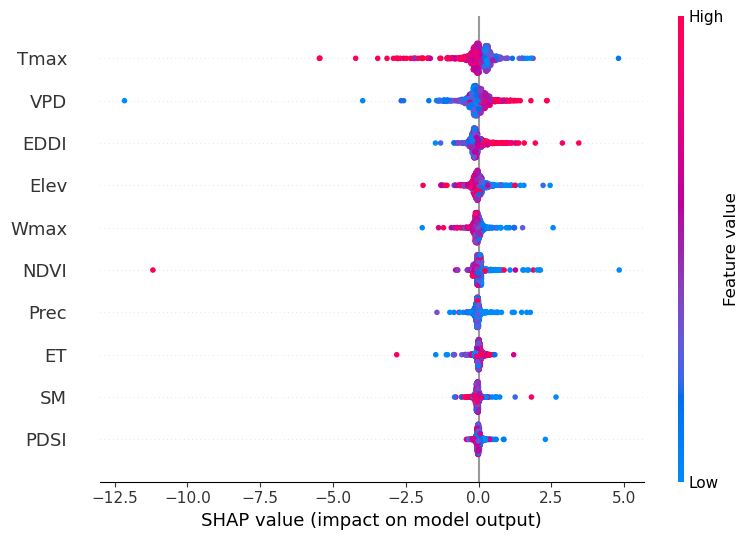

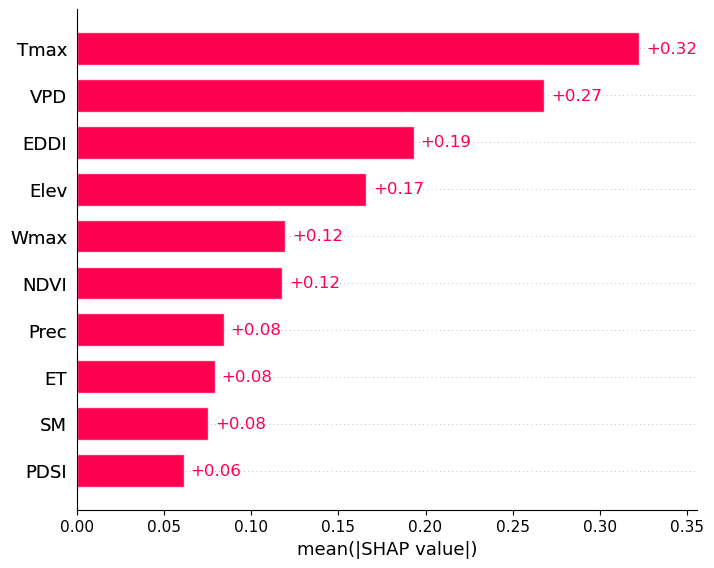

Computing SHAP values for LSTM...


  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 10)


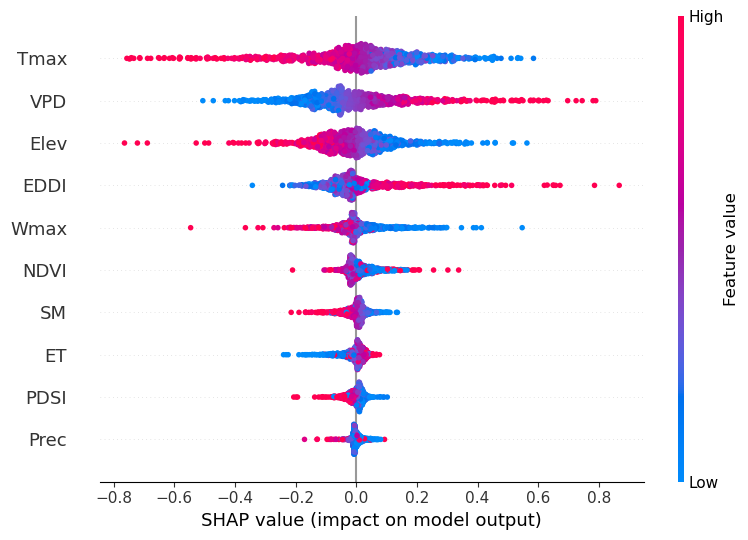

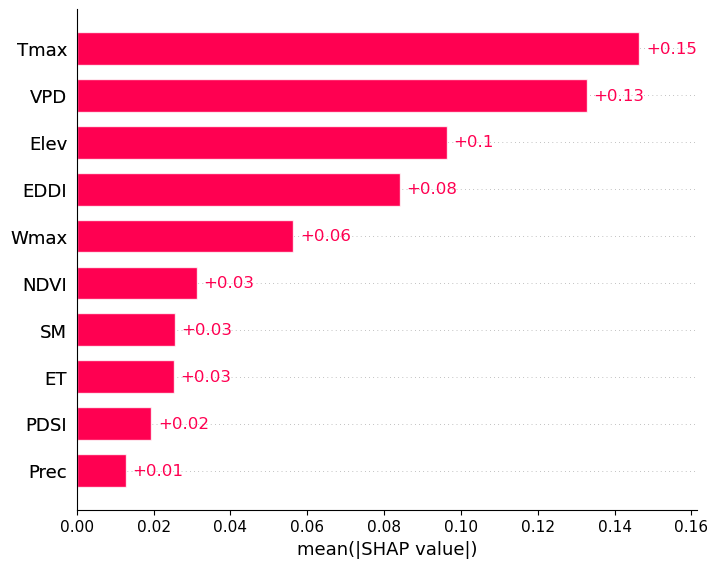

In [18]:
# Compute and plot SHAP values for each model
"""
for model_name, model in all_MLAs.items():
    print(f"Computing SHAP values for {model_name}...")
    compute_and_plot_shap(model, X_train, X_test, feature_names, model_name, subset_fraction=0.1)
"""

"""
# Extract the Decision Tree model
individual_model_name = 'Decision Tree'
individual_model = all_MLAs[individual_model_name]

warnings.filterwarnings("ignore", message="X has feature names, but")


# Print and compute SHAP values for the Decision Tree model only
print(f"Computing SHAP values for {individual_model_name}...")

if individual_model_name == 'LSTM':
    sampled_X_train_tensor = X_train_tensor[torch.randperm(len(X_train_tensor))[:1000000]]
    explainer = shap.DeepExplainer(individual_model, sampled_X_train_tensor)
else:
    explainer = shap.Explainer(individual_model.predict, shap.sample(X_train_df, 1000000))
    shap_values = explainer(shap.sample(X_test_df, 1000))
"""

warnings.filterwarnings("ignore", message="X has feature names, but")

# Compute and plot SHAP values for each model - version 2
for model_name, model in all_MLAs.items(): 
    print(f"Computing SHAP values for {model_name}...")
    if model_name == 'LSTM':
        # Define a function for making predictions
        def predict_fn(x):
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Add time dimension
            with torch.no_grad():
                y_pred_tensor = lstm_trained_model(x_tensor)
            return y_pred_tensor.numpy()

        # Use shap.kmeans to summarize the background data with K samples
        K = 100  # Adjust K based on the dataset size and computational power
        sample_data = shap.kmeans(X_train_df, K)
        #sample_data = shap.sample(X_train_df, 10) #For testing purposes
        
        # Initialize the KernelExplainer with summarized background data
        explainer = shap.KernelExplainer(predict_fn, sample_data)

        # Sample test data for SHAP value computation and plotting
        test_sample = shap.sample(X_test_df, 1000)  # Sample 1000 rows from X_test_df

        # Compute SHAP values using the sampled test data
        shap_values = explainer.shap_values(test_sample)
        print(shap_values[:,:,0].shape) #Found problem: Need to take out extra dimension "1"
        #What is the "1" dimension about? Is it a redundancy or has a purpose? Look into it later.
        shap_values_fitted = shap_values[:,:,0]
        # Ensure that test_sample contains all features
        # Plot SHAP summary using the sampled test data
        
        # Create Explanation object for the shap.plots.bar
        explanation = shap.Explanation(
            values=shap_values_fitted,
            base_values=explainer.expected_value,
            data=test_sample,
            feature_names=X_train_df.columns
        )
        
        # Plot SHAP summary and bar chart
        shap.summary_plot(shap_values_fitted, test_sample)
        shap.plots.bar(explanation)
        
    else: #previously 1000
        sample_data = shap.sample(X_train_df, 1000000)
        explainer = shap.Explainer(model.predict, sample_data)
        
        test_sample = shap.sample(X_test_df, 1000)
        
        shap_values = explainer(test_sample)
        print(shap_values.shape)
        shap.summary_plot(shap_values, test_sample)
        shap.plots.bar(shap_values)
            
#compute_and_plot_shap(individual_model, X_train, X_test, feature_names, individual_model_name, subset_fraction=0.1)

#"Using 1000 background data samples could cause slower run times."
#"Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples."

# Loading models

Loading models to test performance.


Loading Scikit-learn model: Decision Tree_model.pkl

Loading PyTorch model: LSTM_model.pth
Unknown file type for .ipynb_checkpoints, skipping...


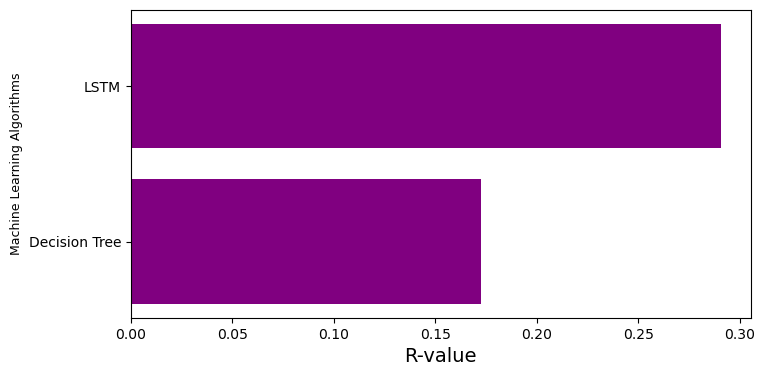

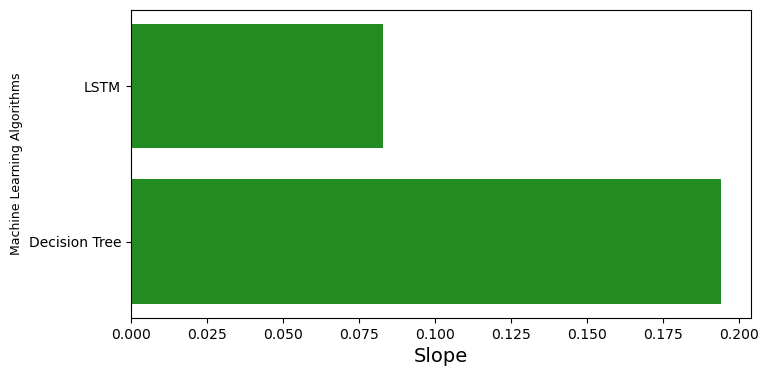

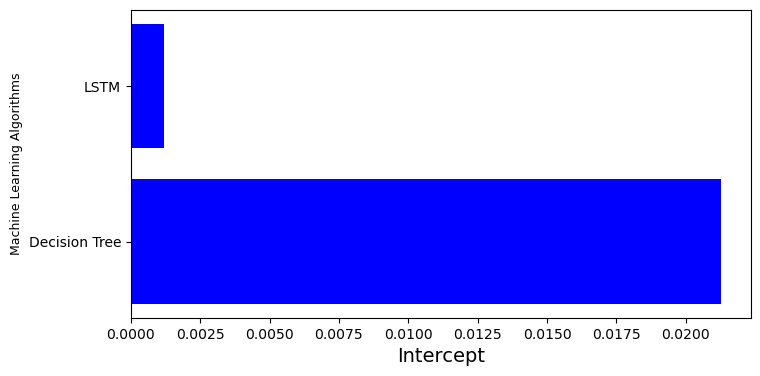

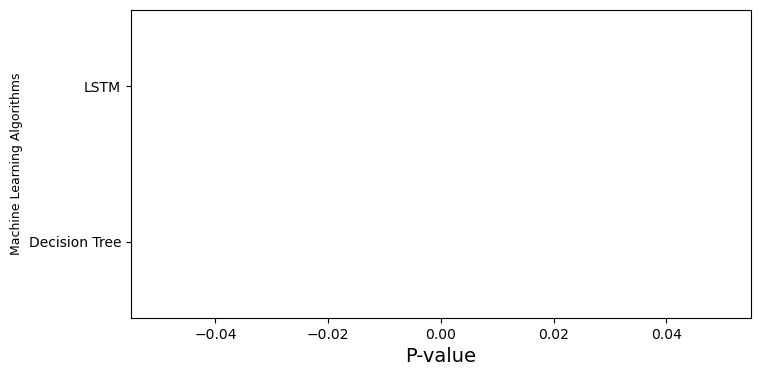

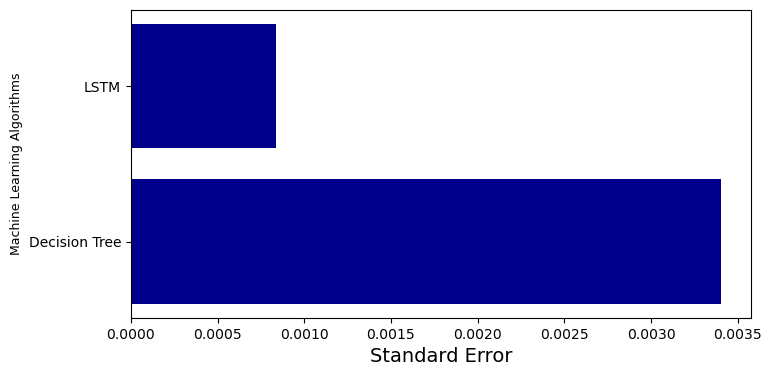


Model performance plotted.


In [20]:
# Define plotting function for horizontal bar charts
def plot_horizontal_bar(ML_name, ML_values, color, label, data_fraction, ylim=None):
    plt.figure(figsize=(8, 4))
    plt.barh(ML_name, ML_values, color=color)
    plt.xlabel(label, fontsize='14')
    plt.ylabel(set_ylabel(data_fraction), fontsize='9')
    if ylim:
        plt.xlim(ylim)
    plt.show()

def set_ylabel(data_fraction):
    return (
        'Machine Learning Algorithms' if data_fraction == 1.0
        else f'Machine Learning Algorithms ({data_fraction * 100:.0f}% Data)'
    )

# Create directory path where models are saved
save_dir = 'saved_algorithms'

# Sample a fraction of the data (assuming you have X_test, Y_test ready)
X_test_sample = X_test
Y_test_sample = Y_test

# Initialize lists to store predictions and results
ML_name = []
ML_r_value = []
ML_p_value = []
ML_slope = []
ML_intercept = []
ML_std_err = []

# Loop through all files in the saved_algorithms directory
for file_name in os.listdir(save_dir):
    model_path = os.path.join(save_dir, file_name)
    
    # Check if the file is a PyTorch model (.pth) or Scikit-learn model (.pkl)
    if file_name.endswith('.pth'):
        # For PyTorch (LSTM or other neural network models)
        print(f"\nLoading PyTorch model: {file_name}")

        # Assuming model name is part of the filename before ".pth"
        model_name = file_name.replace('_model.pth', '')
        model = LSTMModel(input_dim=X_test.shape[1], hidden_dim=50, output_dim=1)  # Replace with actual model architecture

        # Load only the weights (state_dict) instead of the entire model to avoid security risks
        # Added handling for FutureWarning on torch.load() usage
        model.load_state_dict(torch.load(model_path, weights_only=True))

        # Prepare test data for LSTM
        X_test_tensor = torch.tensor(X_test_sample, dtype=torch.float32).unsqueeze(1)

        # Predict on the test data
        with torch.no_grad():
            Y_pred_tensor = model(X_test_tensor)
        Y_pred = Y_pred_tensor.squeeze().numpy()

        # Calculate linear regression statistics
        slope, intercept, r_value, p_value, std_err = linregress(Y_test_sample, Y_pred)

        # Append results to respective lists
        ML_slope.append(slope)
        ML_intercept.append(intercept)
        ML_r_value.append(r_value)
        ML_p_value.append(p_value)
        ML_std_err.append(std_err)
        ML_name.append(model_name)
        
    elif file_name.endswith('.pkl'):
        # For Scikit-learn models
        print(f"\nLoading Scikit-learn model: {file_name}")
        
        # Assuming model name is part of the filename before ".pkl"
        model_name = file_name.replace('_model.pkl', '')

        # Load the Scikit-learn model using pickle
        with open(model_path, 'rb') as file:
            model = pickle.load(file)

        # Predict on the test data
        Y_pred = model.predict(X_test_sample)

        # Calculate linear regression statistics
        slope, intercept, r_value, p_value, std_err = linregress(Y_test_sample, Y_pred)

        # Append results to respective lists
        ML_slope.append(slope)
        ML_intercept.append(intercept)
        ML_r_value.append(r_value)
        ML_p_value.append(p_value)
        ML_std_err.append(std_err)
        ML_name.append(model_name)

    else:
        print(f"Unknown file type for {file_name}, skipping...")

# Plot performance metrics for each model
Training_Fraction = 1  # Assuming full dataset was used for testing

# Plot R-values
plot_horizontal_bar(ML_name, ML_r_value, 'purple', 'R-value', Training_Fraction)
# Plot Slope
plot_horizontal_bar(ML_name, ML_slope, 'forestgreen', 'Slope', Training_Fraction)
# Plot Intercept
plot_horizontal_bar(ML_name, ML_intercept, 'blue', 'Intercept', Training_Fraction)
# Plot P-value
plot_horizontal_bar(ML_name, ML_p_value, 'red', 'P-value', Training_Fraction)
# Plot Standard Error
plot_horizontal_bar(ML_name, ML_std_err, 'darkblue', 'Standard Error', Training_Fraction)

# Finish plotting
print("\nModel performance plotted.")


# SHAP with saved models


SHAP for Scikit-learn model: Decision Tree_model.pkl


ExactExplainer explainer: 1001it [00:25, 23.89it/s]                                                                     


(1000, 10)


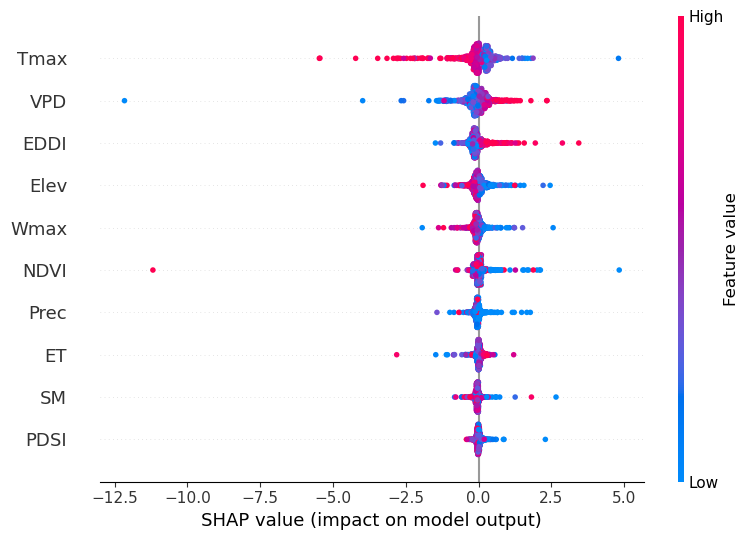

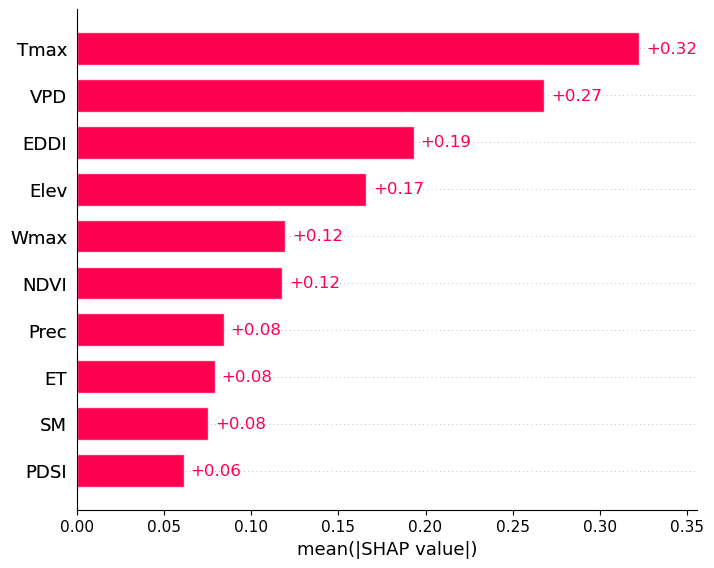


Loading PyTorch model: LSTM_model.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 10)


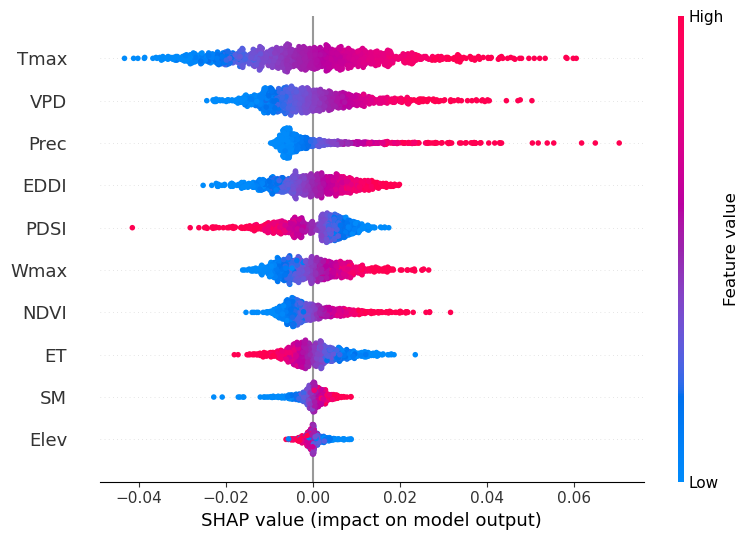

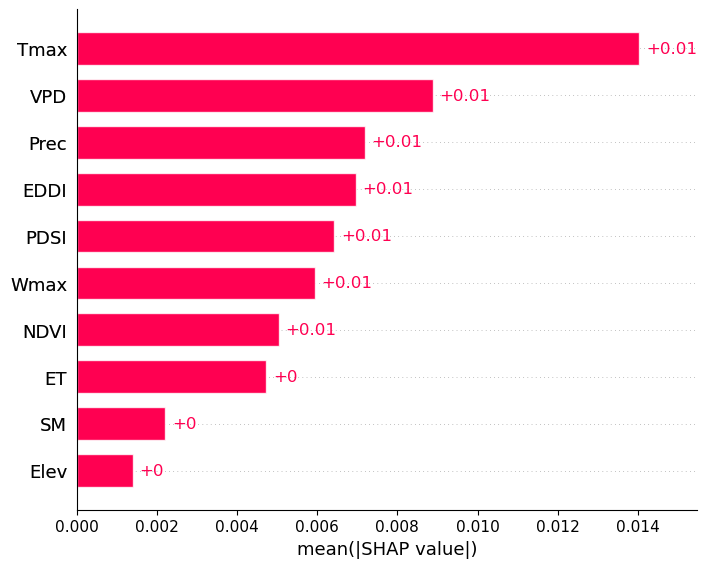

In [28]:
warnings.filterwarnings("ignore", message="X has feature names, but")

for file_name in os.listdir(save_dir):
    model_path = os.path.join(save_dir, file_name)
    
    if file_name.endswith('.pth'):
        # For PyTorch (LSTM or other neural network models)
        print(f"\nLoading PyTorch model: {file_name}")

        # Assuming model name is part of the filename before ".pth"
        model_name = file_name.replace('_model.pth', '')
        model = LSTMModel(input_dim=X_test.shape[1], hidden_dim=50, output_dim=1)  # Replace with actual model architecture

        # Define a function for making predictions
        def predict_fn(x):
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Add time dimension
            with torch.no_grad():
                y_pred_tensor = model(x_tensor)
            return y_pred_tensor.numpy()
        
        # Use shap.kmeans to summarize the background data with K samples
        K = 100  # Adjust K based on the dataset size and computational power
        sample_data = shap.kmeans(X_train_df, K)
        #sample_data = shap.sample(X_train_df, 10) #For testing purposes
        
        # Initialize the KernelExplainer with summarized background data
        explainer = shap.KernelExplainer(predict_fn, sample_data)

        # Sample test data for SHAP value computation and plotting
        test_sample = shap.sample(X_test_df, 1000)  # Sample 1000 rows from X_test_df

        # Compute SHAP values using the sampled test data
        shap_values = explainer.shap_values(test_sample)
        print(shap_values[:,:,0].shape) #Found problem: Need to take out extra dimension "1"
        #What is the "1" dimension about? Is it a redundancy or has a purpose? Look into it later.
        shap_values_fitted = shap_values[:,:,0]
        # Ensure that test_sample contains all features
        # Plot SHAP summary using the sampled test data
        
        # Create Explanation object for the shap.plots.bar
        explanation = shap.Explanation(
            values=shap_values_fitted,
            base_values=explainer.expected_value,
            data=test_sample,
            feature_names=X_train_df.columns
        )
        
        # Plot SHAP summary and bar chart
        shap.summary_plot(shap_values_fitted, test_sample)
        shap.plots.bar(explanation)
        
    if file_name.endswith('.pkl'):
        # For Scikit-learn models
        print(f"\nSHAP for Scikit-learn model: {file_name}")
        
        # Assuming model name is part of the filename before ".pkl"
        model_name = file_name.replace('_model.pkl', '')

        # Load the Scikit-learn model using pickle
        with open(model_path, 'rb') as file:
            model = pickle.load(file)
            sample_data = shap.sample(X_train_df, 1000000)
            explainer = shap.Explainer(model.predict, sample_data)

            test_sample = shap.sample(X_test_df, 1000)

            shap_values = explainer(test_sample)
            print(shap_values.shape)
            shap.summary_plot(shap_values, test_sample)
            shap.plots.bar(shap_values)
    